In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [49]:
sales_temp = pd.read_csv("/content/drive/MyDrive/Forecasting/FRED-LTOTALNSA.csv", index_col='Date', parse_dates=True)
sales = sales_temp[::-1]
sales

,Value
Date,
1976-01-01,864.600
1976-02-01,973.300
1976-03-01,1216.100
1976-04-01,1163.200
1976-05-01,1176.100
...,...
2021-09-01,1015.935
2021-10-01,1051.015
2021-11-01,1014.411


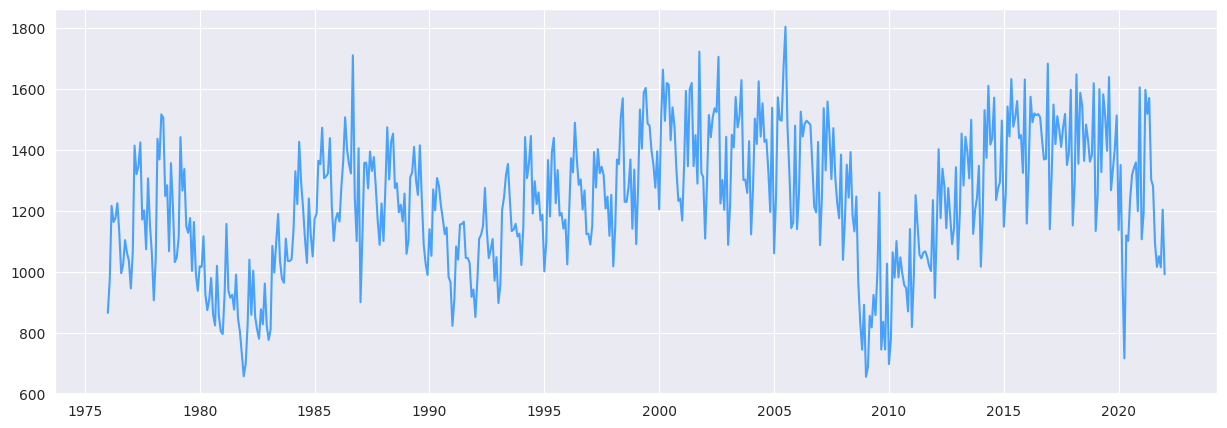

In [50]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sales, c='#48A1FA')
plt.show()

**Checking For stationarity**

**Histogram plot**

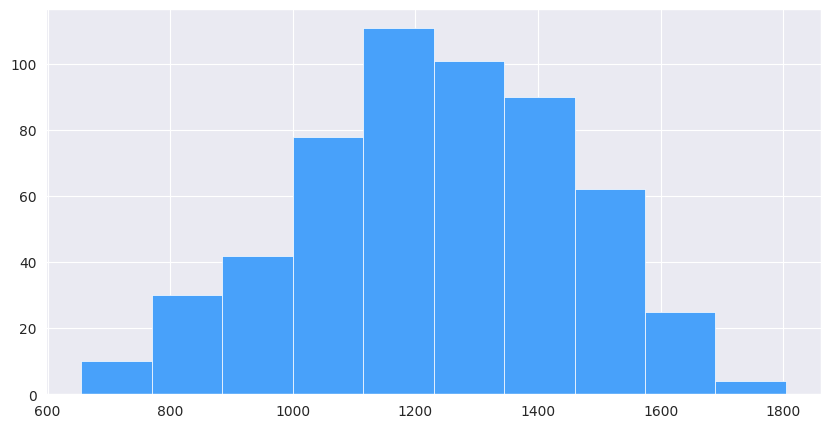

In [51]:
pd.Series(sales['Value']).hist(color="#48A1FA", figsize=(10,5));

**Checking Mean and Variance over small chunks**

In [52]:
sales_chunks = np.split(sales['Value'][:-1], 12)
means = np.round(np.mean(sales_chunks, axis=1), 2)
stds = np.round(np.std(sales_chunks, axis=1), 2)
chunks_df = pd.DataFrame({'chunks': list(range(1, len(sales_chunks)+1)), 'mean_values': means, 'variance_vals': stds})
chunks_df

,chunks,mean_values,variance_vals
0,1,1179.55,159.80
1,2,913.36,117.68
2,3,1244.12,157.88
3,4,1198.75,145.96
4,5,1137.80,135.49
5,6,1269.35,122.10
6,7,1424.70,155.97
7,8,1400.43,165.77
8,9,1097.21,248.69
9,10,1169.00,169.68


**Augumented Dicket-Fuller test**

In [53]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, critical_vals, icbest = adfuller(sales['Value'])

In [54]:
print('P value',pval)
print(adf)
print(icbest)
print(usedlag)
print(critical_vals)

P value 0.06222490024371673
-2.773068557093062
6531.654553617461
17
{'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}


**Time series is non-stationary**

**KPSS test**

In [55]:
import pandas as pd
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_stat, p_value, lags, critical_values = kpss(sales['Value'])

print("KPSS Statistic:", kpss_stat)
print("p-value:", p_value)
print("Lags:", lags)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Statistic: 0.8338589773490158
p-value: 0.01
Lags: 14
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


**Time series is non-stationary**

In [56]:
import statsmodels.api as sm
from statsmodels.compat import lzip
const_array = np.ones_like(sales)

reg_model = sm.OLS(sales, const_array).fit()

# Calculate the residuals
residuals = reg_model.resid

bp_model = sm.OLS(residuals**2, const_array).fit()

# Perform the Breusch-Pagan test
bp_test = bp_model.get_robustcov_results(cov_type='HC1')
test_statistic = bp_test.bse[0]
p_value = bp_test.pvalues[0]

print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic)
print("p-value:", p_value)

Breusch-Pagan Test Results:
Test Statistic: 2552.302667089003
p-value: 2.3447502619211134e-61


**The time series is non-stationary and there is a high chance of Heteroscedasticity**

**Decomposition of time series into Trend, Seasonal, and Residuals components**

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=sales, model = 'additive', period=12)
trend = ss_decomposition.trend
seasonal = ss_decomposition.seasonal
residual = ss_decomposition.resid

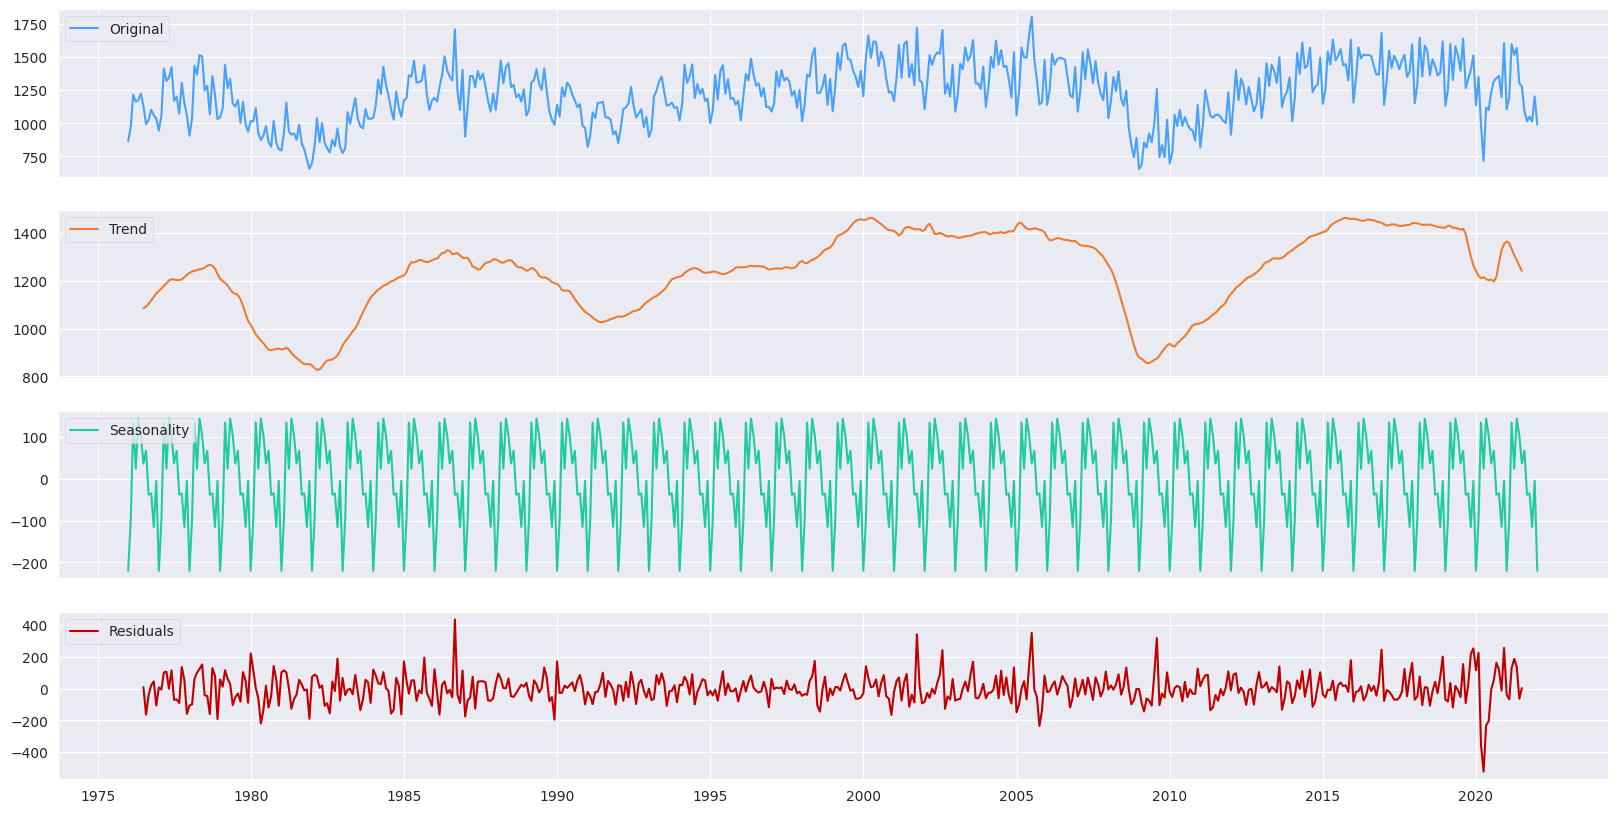

In [58]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(sales.Value, label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

**Rollin mean and standar deviation plots**

In [59]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(18, 7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -2.773069
p-value                   0.062225
Lags Used                17.000000
Observations Used       535.000000
Critical Value (1%)      -3.442632
Critical Value (5%)      -2.866957
Critical Value (10%)     -2.569655
dtype: float64


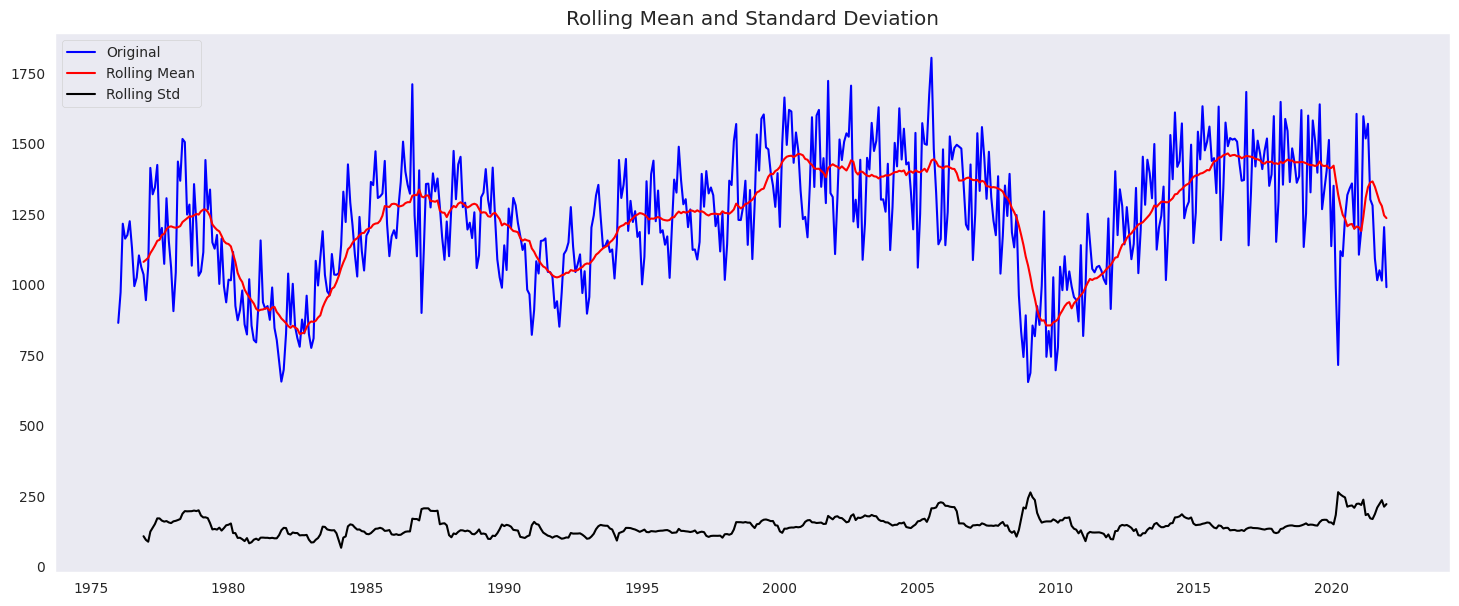

In [60]:
dftest(sales['Value'])

**Making Time Series statioanry by making necessary transformations**

In [61]:
sales['difference'] = sales['Value'].diff(12)

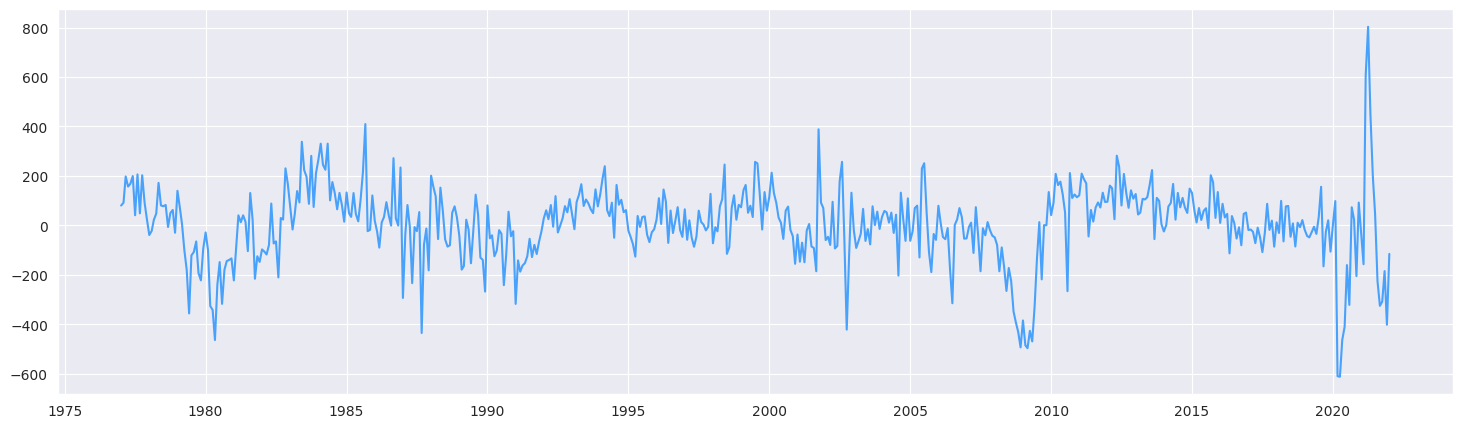

In [62]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(sales.difference, c='#48A1FA')
plt.show()

**Making all the values positive to apply log transformation**`

In [63]:
print(min(sales[12:].difference))

-611.916


In [64]:
sales['difference_positive'] = sales['difference'] + 612

In [65]:
sales['log_transformed'] = np.log(sales.difference_positive)

In [67]:
sales = sales.dropna()
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541 entries, 1977-01-01 to 2022-01-01
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Value                541 non-null    float64
 1   difference           541 non-null    float64
 2   difference_positive  541 non-null    float64
 3   log_transformed      541 non-null    float64
dtypes: float64(4)
memory usage: 21.1 KB


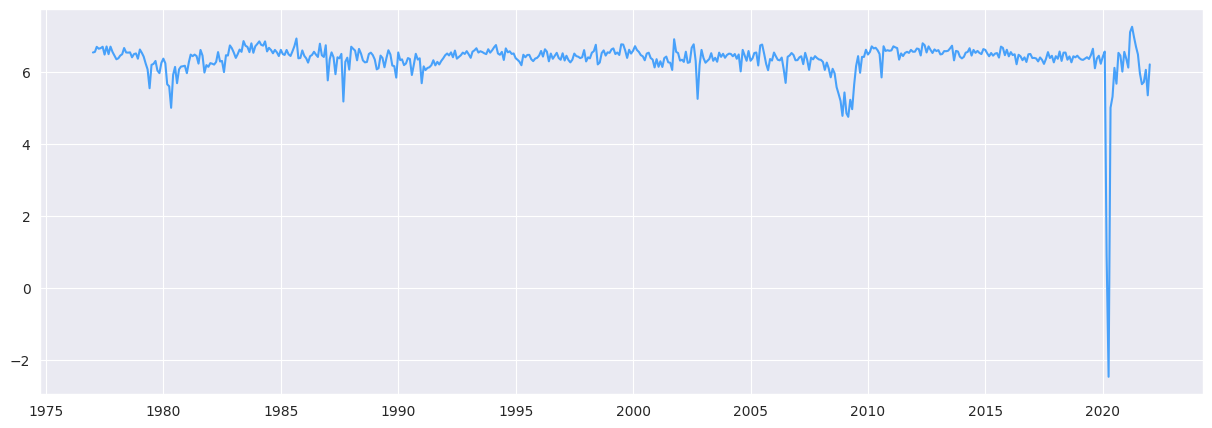

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sales.log_transformed, c='#48A1FA')
plt.show()

**Now it looks like stationary, let's confirm with ADF, KPSS and Breusch-Pagan Tests**

**ADF test**

In [69]:
adf1, pval1, usedlag1, nobs1, critical_vals1, icbest1 = adfuller(sales['log_transformed'])
print('P value',pval1)
print(adf1)
print(icbest1)
print(usedlag1)
print(critical_vals1)

P value 5.083188612440649e-15
-9.042687965041363
634.8047771734343
2
{'1%': -3.442563336759378, '5%': -2.866927190004947, '10%': -2.5696391843672695}


**KPSS test**

In [70]:
# Perform the KPSS test
kpss_stat1, p_value1, lags1, critical_values1 = kpss(sales['log_transformed'][12:])

# Print the test results
print("KPSS Statistic:", kpss_stat1)
print("p-value:", p_value1)
print("Lags:", lags1)
print("Critical Values:")
for key, value in critical_values1.items():
    print(f"  {key}: {value}")

KPSS Statistic: 0.18452536679125126
p-value: 0.1
Lags: 11
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [71]:
const_array1 = np.ones_like(sales.log_transformed[12:])
reg_model1 = sm.OLS(sales.log_transformed[12:], const_array1).fit()

# Calculate the residuals
residuals1 = reg_model1.resid

bp_model1 = sm.OLS(residuals1**2, const_array1).fit()

# Perform the Breusch-Pagan test
bp_test1 = bp_model1.get_robustcov_results(cov_type='HC1')
test_statistic1 = bp_test1.bse[0]
p_value1 = bp_test1.pvalues[0]

# Print the test results
print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic1)
print("p-value:", p_value1)

Breusch-Pagan Test Results:
Test Statistic: 0.15796893353509986
p-value: 0.0601600447533735


In [73]:
from tabulate import tabulate

adf_pvalue = 5.083188612440649e-15
kpss_pvalue = 0.1
bp_pvalue = 0.0601600447533735

data = [
    ['ADF Test', adf_pvalue],
    ['KPSS Test', kpss_pvalue],
    ['Breusch-Pagan Test', bp_pvalue]
]

print(tabulate(data, headers=['Test', 'p-value'], tablefmt='fancy_grid'))


╒════════════════════╤═════════════╕
│ Test               │     p-value │
╞════════════════════╪═════════════╡
│ ADF Test           │ 5.08319e-15 │
├────────────────────┼─────────────┤
│ KPSS Test          │ 0.1         │
├────────────────────┼─────────────┤
│ Breusch-Pagan Test │ 0.06016     │
╘════════════════════╧═════════════╛


**All tests say that Time series is stationary**

**Decomposing the transformed time series**

In [74]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541 entries, 1977-01-01 to 2022-01-01
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Value                541 non-null    float64
 1   difference           541 non-null    float64
 2   difference_positive  541 non-null    float64
 3   log_transformed      541 non-null    float64
dtypes: float64(4)
memory usage: 21.1 KB


In [75]:
ss_decomposition1 = seasonal_decompose(x=sales.log_transformed, model = 'additive', period=12)
trend1 = ss_decomposition1.trend
seasonal1 = ss_decomposition1.seasonal
residual1 = ss_decomposition1.resid

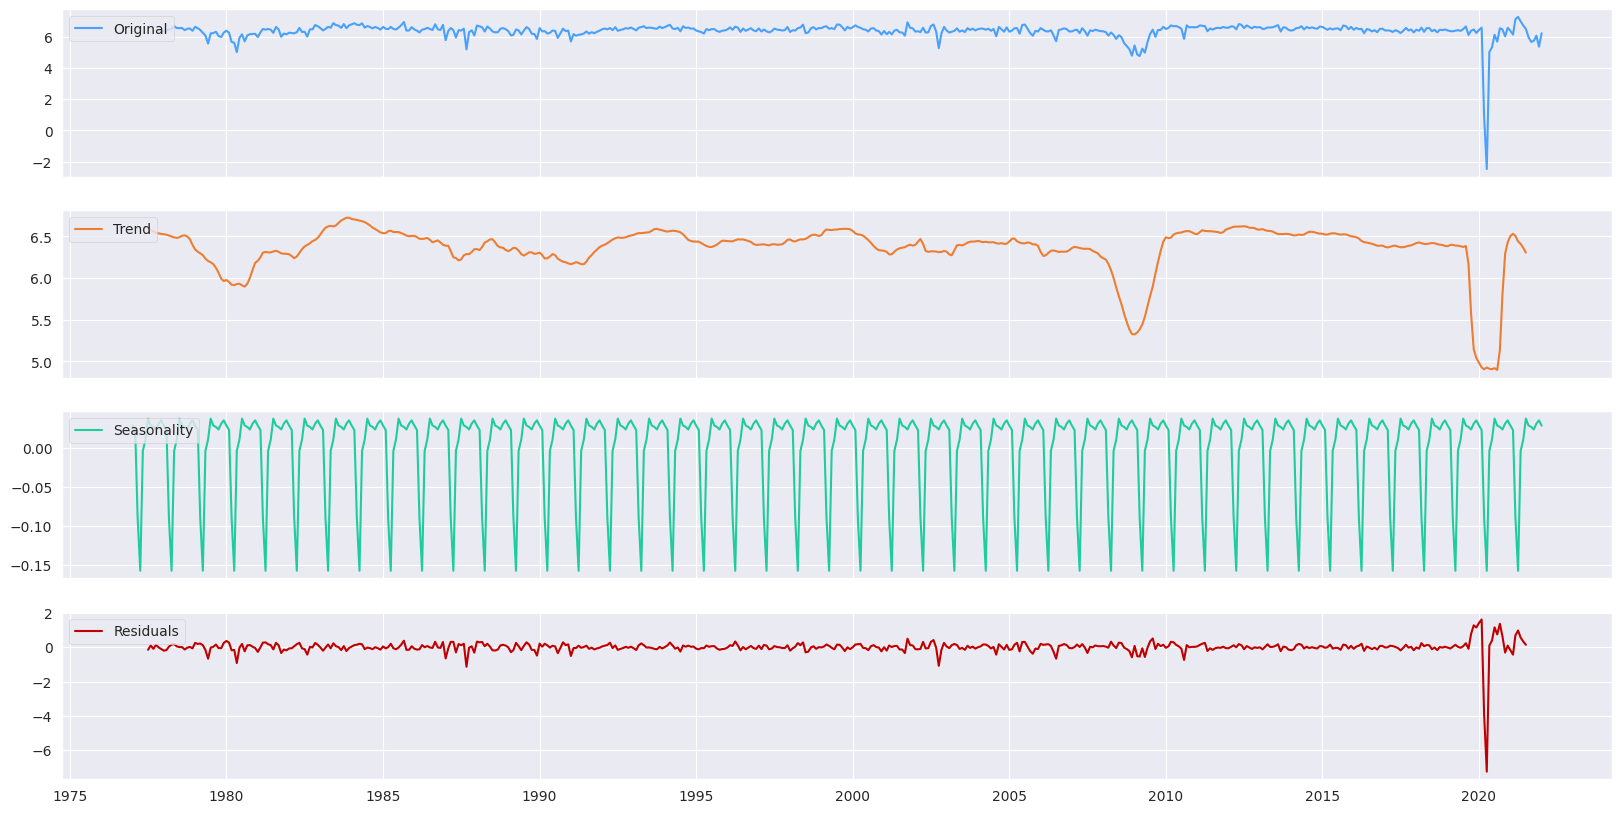

In [76]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(sales.log_transformed[12:], label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend1, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal1, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual1, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

**ACF and PACF plots**

In [77]:
from statsmodels.graphics.tsaplots import acf, plot_acf

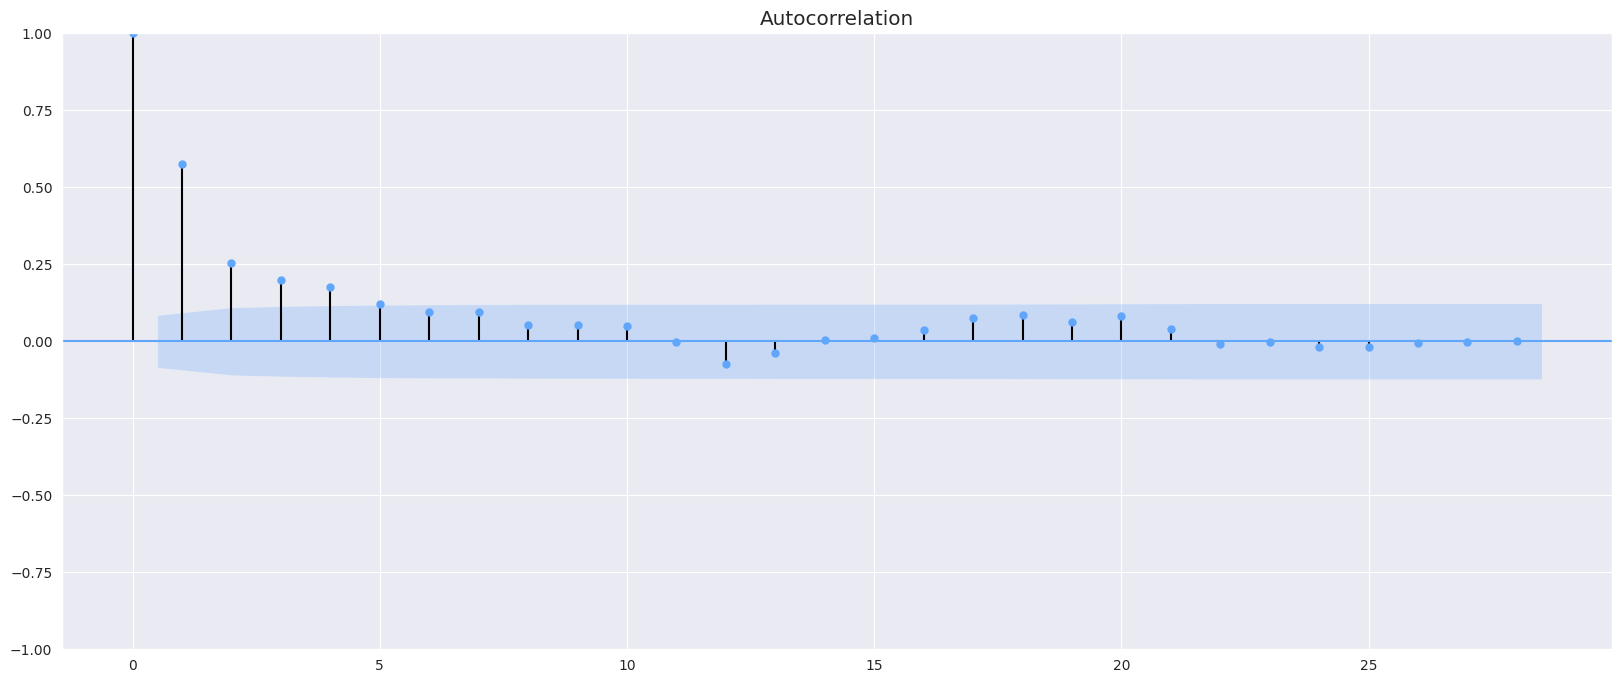

In [78]:
from matplotlib.collections import PolyCollection
fig, ax = plt.subplots(figsize=(20,8))
plot_acf(sales.log_transformed[12:], ax=ax,
         color='#60A6FB',
         vlines_kwargs={"colors": '#000000'})

for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('#60A6FB')

plt.show()

In [79]:
from statsmodels.graphics.tsaplots import pacf, plot_pacf

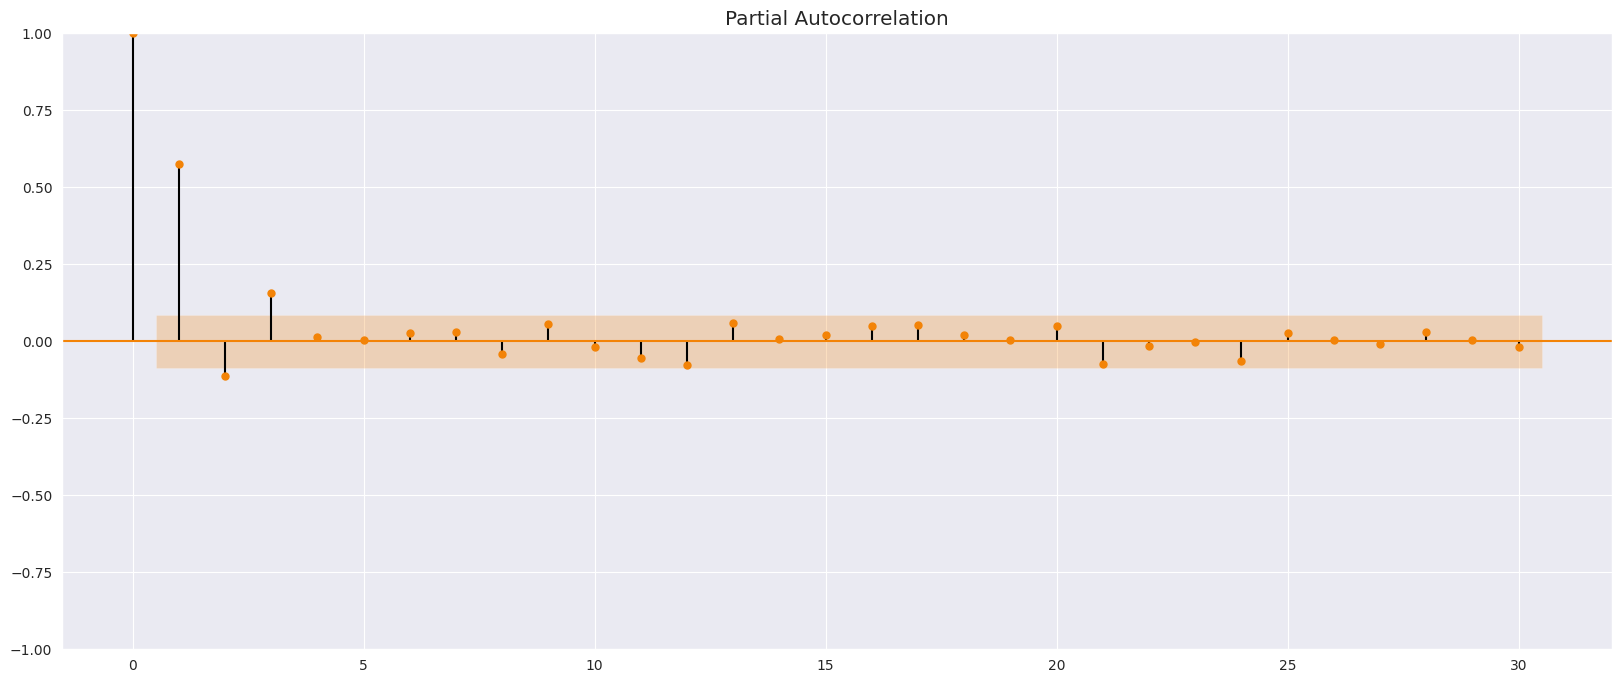

In [80]:
fig, ax = plt.subplots(figsize=(20,8))

plot_pacf(sales.log_transformed[12:],
          lags=30, ax=ax, color='#F38307',
          vlines_kwargs={"colors": '#000000'})

for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('#F38307')

plt.show()

**Based on this plots AR = 3, MA = 4**

**Let's fit model based on ACF and PACF plots**

**Lets use Auto ARIMA to select the best parameters**

In [31]:
!pip install git+https://github.com/statsmodels/statsmodels.git
!pip install pmdarima
import pmdarima as pm
#!pip install pmdarima-1.7.1-cp37-cp37m-win_amd64.whl
#from pyramid.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-bamdzy5g
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-bamdzy5g
  Resolved https://github.com/statsmodels/statsmodels.git to commit 803b841d2dbf6d6b463523c5a75bc87aa82f25bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statsmodels: filename=statsmodels-0.15.0.dev24+g803b841d2-cp310-cp310-linux_x86_64.whl size=23240976 sha256=f854412fbbd60ac28d9f58eb3f77f6e4e986e2cbadc58164d0d5605ad37911a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7gmgk8bf/wheels/63/99/aa/bb07110a6e10e2d86fabb8c067f39ed97d662d486bb01ca22b
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s eta 0:00:00


In [81]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Split the data into training and testing sets
train_data = sales['log_transformed']

# Define the parameter ranges for grid search
p_range = range(0, 6)  # Autoregressive order
d_range = range(0, 2)  # Differencing order
q_range = range(0, 6)  # Moving average order
P_range = range(0, 3)  # Seasonal autoregressive order
D_range = range(0, 3)  # Seasonal differencing order
Q_range = range(0, 3)  # Seasonal moving average order
s = 12  # Seasonal period

# Perform grid search to find the best parameters
model = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=5, max_q=5,
                      start_P=0, start_D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                      seasonal=True, m=s, stepwise=True, suppress_warnings=True)

# Get the best model parameters
best_order = model.order
best_seasonal_order = model.seasonal_order

print("Best SARIMA order:", best_order)
print("Best seasonal order:", best_seasonal_order)

Best SARIMA order: (1, 0, 2)
Best seasonal order: (0, 0, 2, 12)


In [82]:
sarima = sm.tsa.statespace.SARIMAX(sales.log_transformed,
                                order=(1,0,2),
                                seasonal_order=(0,0,2,12),
                                trend='c').fit()
sarima.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  if isinstance(retvals, dict):


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    log_transformed   No. Observations:                  541
Model:             SARIMAX(1, 0, 2)x(0, 0, 2, 12)   Log Likelihood                -311.424
Date:                            Fri, 23 Jun 2023   AIC                            636.848
Time:                                    08:14:02   BIC                            666.902
Sample:                                01-01-1977   HQIC                           648.601
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2745      0.300      4.254      0.000       0.687       1.862
ar.L1          0.7995      0.048     16.621      0.000       0.705       0.894
ma.L1         -0.1488      0.049     -3.062      0.002      -0.244      -0.054
ma.L2         -0.2949      0.034     -8.554      0.000      -0.362      -0.227
ma.S.L12      -0.1336      0.057     -2.359      0.018      -0.245      -0.023
ma.S.L24      -0.1662      0.146     -1.137      0.256      -0.453       0.120
sigma2         0.1854      0.003     54.418      0.000       0.179       0.192
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            219514.25
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               8.10   Skew:                            -6.63
Prob(H) (two-sided):                  0.00   Kurtosis:                       100.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
arma = sm.tsa.statespace.SARIMAX(sales.log_transformed,
                                order=(3,0,4),
                                seasonal_order=(0,0,0,0),
                                trend='c').fit()
arma.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_transformed   No. Observations:                  541
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -316.397
Date:                Fri, 23 Jun 2023   AIC                            650.794
Time:                        08:30:11   BIC                            689.435
Sample:                    01-01-1977   HQIC                           665.905
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9746      2.323      0.850      0.395      -2.578       6.527
ar.L1          0.3054      2.270      0.135      0.893      -4.143       4.754
ar.L2          0.0875      1.349      0.065      0.948      -2.557       2.731
ar.L3          0.2968      1.001      0.297      0.767      -1.665       2.258
ma.L1          0.3488      2.268      0.154      0.878      -4.097       4.795
ma.L2         -0.0721      0.761     -0.095      0.924      -1.564       1.420
ma.L3         -0.2834      1.086     -0.261      0.794      -2.411       1.844
ma.L4         -0.0962      0.526     -0.183      0.855      -1.127       0.934
sigma2         0.1884      0.004     49.129      0.000       0.181       0.196
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            196281.42
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.51   Skew:                            -6.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        95.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Lets Fit ARMA model**

In [85]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541 entries, 1977-01-01 to 2022-01-01
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Value                541 non-null    float64
 1   difference           541 non-null    float64
 2   difference_positive  541 non-null    float64
 3   log_transformed      541 non-null    float64
dtypes: float64(4)
memory usage: 21.1 KB


# **Forecasting**

# **ARMA**

In [93]:
sales['arma_forecast'] = sarima.predict(start = 0, end= sales.shape[0]-1)

**Undoing the time series transformation**

In [95]:
sales['temp_forecast_ARMA_expo'] = np.exp(sales['arma_forecast'])

In [96]:
sales['temp_forecast_ARMA_sub'] = sales['temp_forecast_ARMA_expo'] - 612

In [97]:
sales['Forecast_ARMA'] = sales['temp_forecast_ARMA_sub'].shift(12) + sales['Value'].shift(12)

In [98]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541 entries, 1977-01-01 to 2022-01-01
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Value                    541 non-null    float64
 1   difference               541 non-null    float64
 2   difference_positive      541 non-null    float64
 3   log_transformed          541 non-null    float64
 4   forecast                 12 non-null     float64
 5   arma_forecast            541 non-null    float64
 6   temp_forecast_ARMA_expo  541 non-null    float64
 7   temp_forecast_ARMA_sub   541 non-null    float64
 8   Forecast_ARMA            529 non-null    float64
dtypes: float64(9)
memory usage: 42.3 KB


In [ ]:
#energy['tem_forecast_5'] = energy['tem_forecast_3'].shift(12) + energy['seasonal_difference']

**Forecasting**

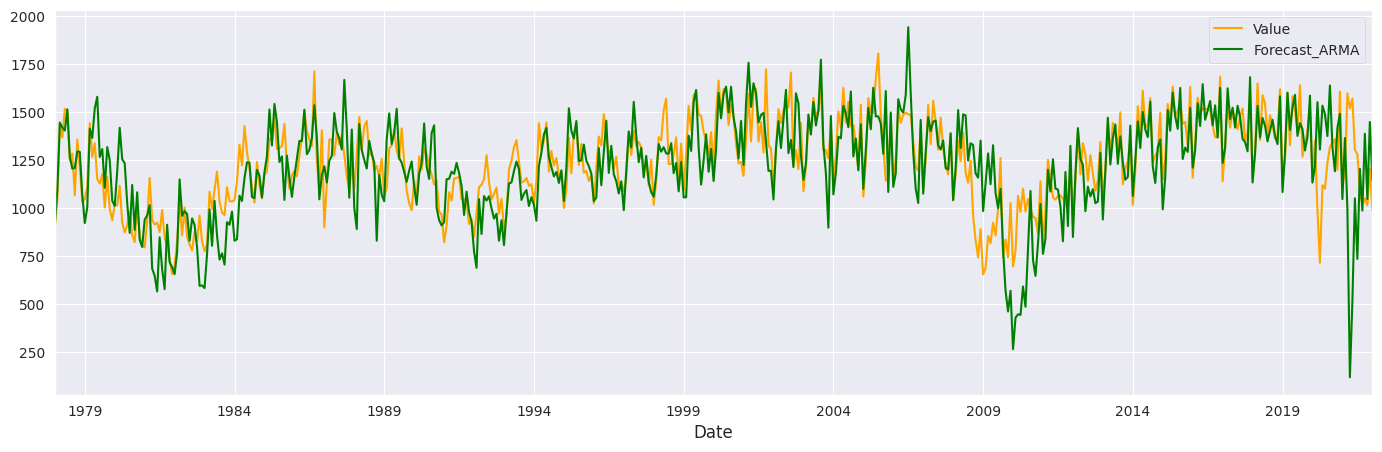

In [101]:
pd.plotting.register_matplotlib_converters()
sales[12:][['Value', 'Forecast_ARMA']].plot(color = ('orange','g'), figsize = (17,5));

**Evaluating ARMA model**

In [104]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(sales['Value'][12:], sales['Forecast_ARMA'][12:])
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 181.21239142529998


In [105]:
from sklearn.metrics import mean_absolute_percentage_error

# Drop rows with null values
#sales = sales.dropna()

# Calculate MAPE
mape = mean_absolute_percentage_error(sales['Value'][12:], sales['Forecast_ARMA'][12:]) * 100
print("MAPE:", mape)

MAPE: 10.607704789043005


In [106]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with null values
#sales = sales.dropna()

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(sales[['Value', 'Forecast_ARMA']])
sales['Value_scaled'] = scaled_sales[:, 0]
sales['Forecast_scaled'] = scaled_sales[:, 1]

# Calculate RMSE on scaled data
mse = mean_squared_error(sales['Value_scaled'][12:], sales['Forecast_scaled'][12:])
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 0.16318710003312062


In [108]:
from tabulate import tabulate
mape = 10.607704789043005
rmse = 181.21239142529998
rmse_minmax = 0.16318710003312062

table = [
    ["MAPE", mape],
    ["RMSE", rmse],
    ["RMSE (MinMax Scaled)", rmse_minmax]
]
headers = ["Metric", "Value"]
table_str = tabulate(table, headers, tablefmt="fancy_grid")
print(table_str)


╒══════════════════════╤════════════╕
│ Metric               │      Value │
╞══════════════════════╪════════════╡
│ MAPE                 │  10.6077   │
├──────────────────────┼────────────┤
│ RMSE                 │ 181.212    │
├──────────────────────┼────────────┤
│ RMSE (MinMax Scaled) │   0.163187 │
╘══════════════════════╧════════════╛


# **SARIMA**

In [109]:
sales['temp_forecast_SARIMA'] = sarima.predict(start = 0, end= sales.shape[0]-1)

In [110]:
sales['temp_forecast_SARIMA_expo'] = np.exp(sales['temp_forecast_SARIMA'])

In [111]:
sales['temp_forecast_SARIMA_sub'] = sales['temp_forecast_SARIMA_expo'] - 612

In [112]:
sales['Forecast_SARIMA'] = sales['temp_forecast_SARIMA_sub'].shift(12) + sales['Value'].shift(12)

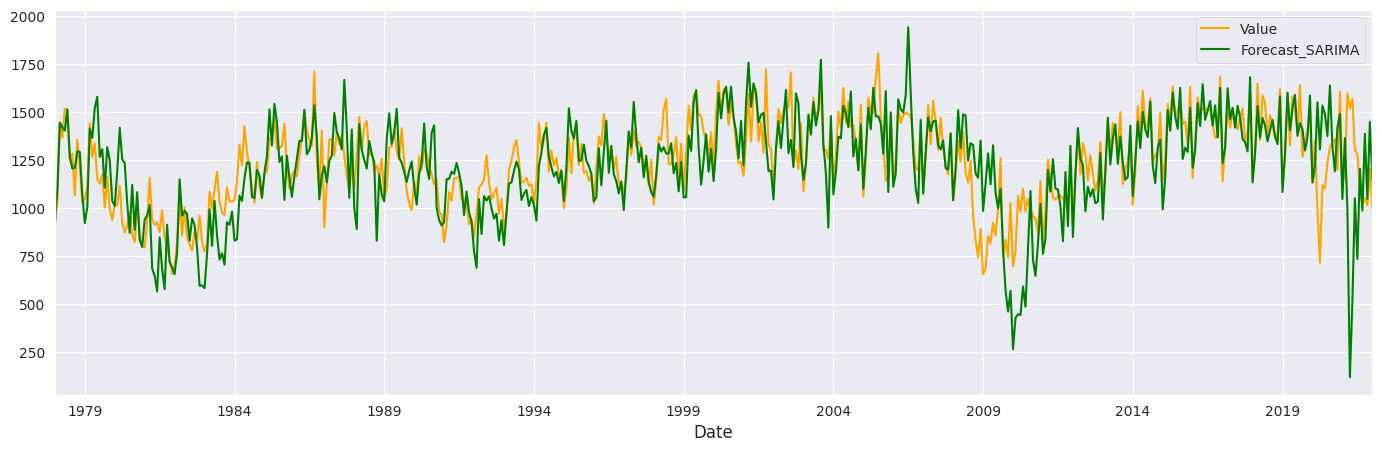

In [113]:
pd.plotting.register_matplotlib_converters()
sales[12:][['Value', 'Forecast_SARIMA']].plot(color = ('orange','g'), figsize = (17,5));

**Evaluating SARIMA model**

In [114]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse1 = mean_squared_error(sales['Value'][12:], sales['Forecast_SARIMA'][12:])
rmse1 = np.sqrt(mse1)
print("RMSE:", rmse1)

RMSE: 181.21239142529998


In [121]:
from sklearn.metrics import mean_absolute_percentage_error

# Drop rows with null values
#sales = sales.dropna()

# Calculate MAPE
mape1 = mean_absolute_percentage_error(sales['Value'][12:], sales['Forecast_SARIMA'][12:]) * 100
print("MAPE:", mape1)

MAPE: 10.607704789043005


In [116]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with null values
#sales = sales.dropna()

# Scale the data using MinMaxScaler
scaler1 = MinMaxScaler()
scaled_sales1 = scaler1.fit_transform(sales[['Value', 'Forecast_SARIMA']])
sales['Value_scaled'] = scaled_sales1[:, 0]
sales['Forecast_scaled'] = scaled_sales1[:, 1]

# Calculate RMSE on scaled data
mse2 = mean_squared_error(sales['Value_scaled'][12:], sales['Forecast_scaled'][12:])
rmse2 = np.sqrt(mse2)

print("RMSE:", rmse2)

RMSE: 0.16318710003312062


In [118]:
from tabulate import tabulate
mape = 10.607704789043005
rmse = 181.21239142529998
rmse_minmax = 0.16318710003312062

table = [
    ["MAPE", mape],
    ["RMSE", rmse],
    ["RMSE (MinMax Scaled)", rmse_minmax]
]
headers = ["Metric", "Value"]
table_str = tabulate(table, headers, tablefmt="fancy_grid")
print(table_str)


╒══════════════════════╤════════════╕
│ Metric               │      Value │
╞══════════════════════╪════════════╡
│ MAPE                 │  10.6077   │
├──────────────────────┼────────────┤
│ RMSE                 │ 181.212    │
├──────────────────────┼────────────┤
│ RMSE (MinMax Scaled) │   0.163187 │
╘══════════════════════╧════════════╛


**Future Forecasts**

In [122]:
forecast_periods = 6
future_index = pd.date_range(start=sales.index[-1] + pd.DateOffset(months=1), periods=forecast_periods+1, freq='M')[1:]

# Forecast future values
forecast = sarima.get_forecast(steps=forecast_periods)
predicted_mean = forecast.predicted_mean

# Apply inverse transformation to convert back to the original scale
predicted_mean_difference_positive = np.exp(predicted_mean)
predicted_mean_difference = predicted_mean_difference_positive - 810
predicted_mean_original_scale = sales['Value'].iloc[-1] + np.cumsum(predicted_mean_difference)
# Create a DataFrame with the forecasted values and corresponding dates
forecast_df = pd.DataFrame({'Date': future_index, 'Forecast': predicted_mean_original_scale})

# Print the forecasted values
print(forecast_df)


                 Date     Forecast
2022-02-01 2022-03-31   786.004780
2022-03-01 2022-04-30  1232.599301
2022-04-01 2022-05-31  2791.464004
2022-05-01 2022-06-30  2608.655075
2022-06-01 2022-07-31  2422.960731
2022-07-01 2022-08-31  2176.045075
